In [1]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyperclip

# IMPORTANDO DADOS

In [2]:
path = 'DataBase.csv'
df   = pd.read_csv(path)
df = df.loc[(df.time > 3) & (df.time < 15)]
df = df.reset_index(drop=True)
df.head()

,time,analog
0,3.03,21347
1,3.06,21360
2,3.09,21378
3,3.12,21380
4,3.15,21357


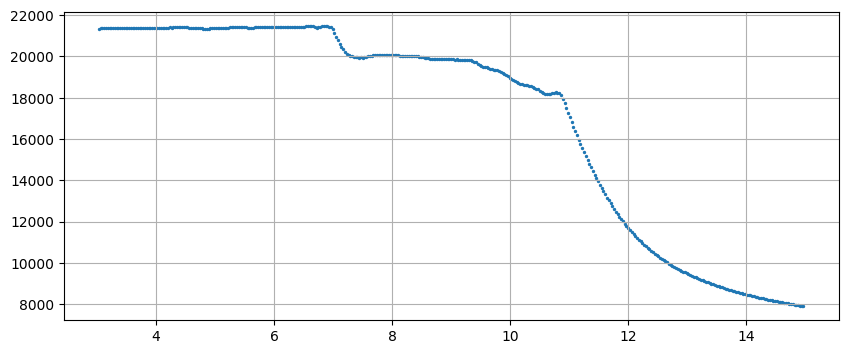

In [3]:
plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.analog, s=2)
plt.grid()

# NORMALIZANDO DADOS

In [4]:
def normalizeTable(df, key, dt=0.15):
    df[key]  = df[key] - df[key][0] # INICIA NO TEMPO 0
    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)
    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})

dt = 0.100
df = normalizeTable(df, 'time', dt)
df

,time,analog
0,0.0,21347
1,0.1,21380
2,0.2,21376
3,0.3,21379
4,0.4,21382
...,...,...
116,11.6,8081
117,11.7,8015
118,11.8,7970
119,11.9,7925


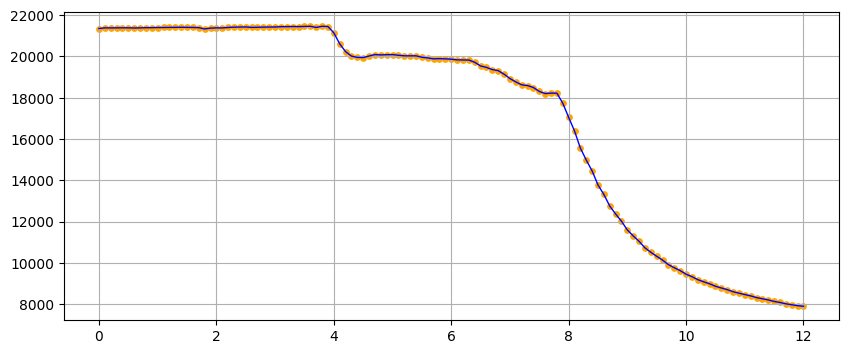

In [5]:
xData, yData = df.time.values, df.analog.values

plt.figure(figsize=(10, 4))
plt.scatter(xData, yData, s=15, color='orange')
plt.plot(xData, yData, linewidth=1, color='blue')
plt.grid()

# FILTRO PERFEITO
**DOMÍNIO DA FREQUÊNCIA** $\Rightarrow$ Fazendo a transformada de Fourier para obter os dados no domínio da frequência, onde o eixo horizontal indica a frequência e o eixo vertical indica a amplitude, geralmente as amplitudes maiores são os alvos desejados, perto de frequências baixas

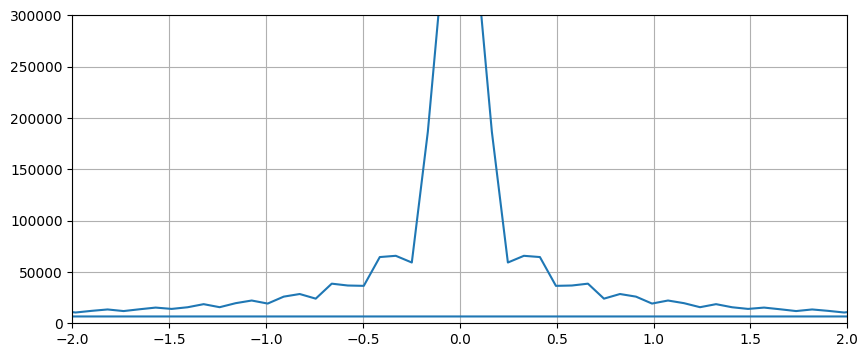

In [6]:
magnitude = np.fft.fft(yData)
frequency = np.fft.fftfreq(len(yData), dt)

plt.figure(figsize=(10, 4))
plt.plot(frequency, np.abs(magnitude))
plt.xlim(-2, 2)
plt.ylim(0, 300000)
plt.grid()

**FILTRO PASSA BAIXA** $\Rightarrow$ O gráfico acima apresenta enorme ruído depois da frequência principal do sistema, o objetivo é eliminar o ruído e impedir com que essas frequências sejam interpretadas

- Isso é feito escolhendo uma frequência de corte, em que tudo que está acima dessa frequência é bloqueada

In [7]:
f_c = 1.0

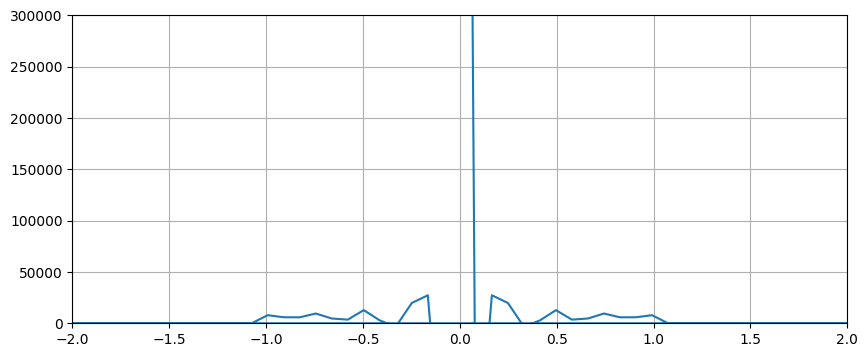

In [8]:
def applyLowBand(frequencyArray, magnitudeArray, upperLimit):
    allowed = np.abs(frequencyArray) <= upperLimit
    magnitudeArray[~allowed] = 0
    return magnitudeArray

magnitude = applyLowBand(frequency, magnitude, f_c)
plt.figure(figsize=(10, 4))
plt.plot(frequency, magnitude.real)
plt.xlim(-2, 2)
plt.ylim(0, 300000)
plt.grid()

- Voltando para o domínio do tempo

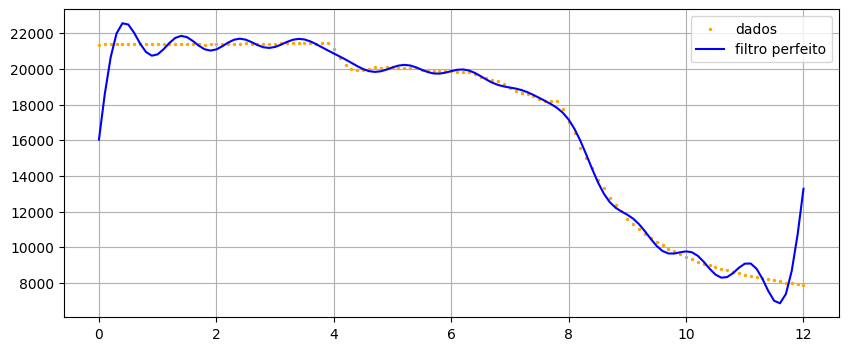

In [9]:
yData = np.fft.ifft(magnitude).real

plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.analog, s=2, color='orange', label='dados')
plt.plot(xData, yData, color='blue', label='filtro perfeito')
plt.legend(), plt.grid()
plt.show()

# FILTRO DE FREQUÊNCIA
A função de transferência do filtro de segunda ordem tem cara: 

- $C(s) = \frac{\omega_n^2}{s^2 + 2\zeta\omega_n s + \omega_n^2}$ $\,\,\,\,\,\,\,\,\,$ onde $\omega_n$ é a frequência natural (ou frequência de corte) do filtro em rad/s.$
- Sabemos que para atenuação ideal, $|C|_{s \to j\omega_c} = \frac{1}{\sqrt{2}} = 0.707 = \zeta$

In [10]:
s = ctl.TransferFunction.s
zeta = 0.7071067811865475
w_n  = 2*np.pi*f_c

C = w_n**2 / (s**2 + 2*zeta*w_n*s + w_n**2)
C

TransferFunction(array([39.4784176]), array([ 1.        ,  8.88576588, 39.4784176 ]))

**COMPARAÇÃO COM O FILTRO PADRÃO** $\Rightarrow$ Vamos comparar o filtro perfeito, construído em numpy, com o filtro feito pela função de transferência, os dois devem ser aproximadamente iguais

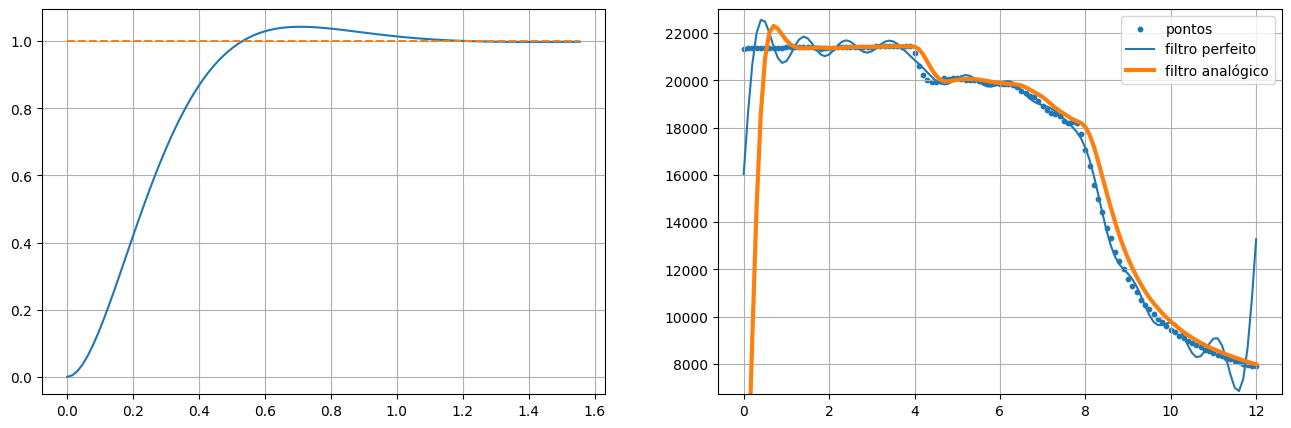

In [11]:
time, response = ctl.step_response(C)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.plot(time, [1 for i in time], '--')
plt.grid()

xTest, yTest  = df.time.values, df.analog.values
timeArray     = np.linspace(xTest[0], xTest[-1], len(xTest))
time, reponse = ctl.forced_response(C, T=timeArray, U=yTest)

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.analog, s=10, label='pontos')
plt.plot(xData, yData, label='filtro perfeito')
plt.plot(time, reponse, label='filtro analógico', linewidth=3)

plt.ylim(min(yData)*0.98, max(yData)*1.02)
plt.legend()
plt.grid()

# FILTRO DIGITAL

In [12]:
C

TransferFunction(array([39.4784176]), array([ 1.        ,  8.88576588, 39.4784176 ]))

In [13]:
s = ctl.TransferFunction.s
C_z = ctl.c2d(C, dt, method='zoh')
C_z

TransferFunction(array([0.14534482, 0.10784998]), array([ 1.       , -1.1580459,  0.4112407]), 0.1)

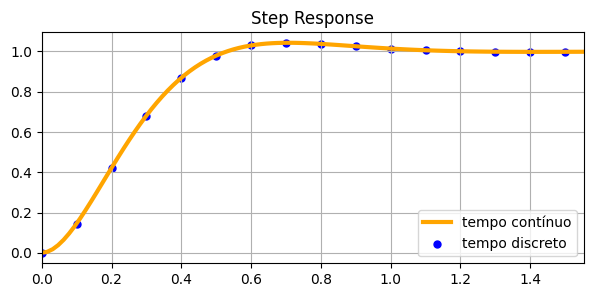

In [14]:
plt.figure(figsize=(7, 3))
time, response = ctl.step_response(C)

plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')
plt.xlim(min(time), max(time))

time, response = ctl.step_response(C_z)
plt.scatter(time, response, color='blue', s=25, label='tempo discreto')

plt.title('Step Response')
plt.legend()
plt.grid()

- As funções abaixo serão usadas para discretizar a função de transferência no domínio $z$ para uma função a partir dos seus estados anteriores

In [15]:
def getFraction(G_z):
    num, den = ctl.tfdata(G_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]

    if type(num) == np.float64:
        num = np.array([num])

    num = [float(val) for val in num]
    den = [float(val) for val in den]
    return (num, den) 


num, den = getFraction(C_z)
print(f'num -> xSize={len(num)}')
print(f'den -> ySize={len(den)}')

num -> xSize=2
den -> ySize=3


In [16]:
def printDigital(num, den):
    out = ''
    
    for i in range(0, len(num)): 
        out += f'Xn{i}*({num[i]:.6f}) + '

    for i in range(1, len(den)): 
        out += f'Yn{i}*({-1*den[i]:.6f}) + '
    
    out = out.replace('Xn0', 'Xn')[:-3] + ';'
    pyperclip.copy(out)
    print(out)


printDigital(num, den)

Xn*(0.145345) + Xn1*(0.107850) + Yn1*(1.158046) + Yn2*(-0.411241);


# OBJETO SISTEMA

In [17]:
class StatesUpdater:
    buffer  = None
    initial = 0
    size    = 0

    def __init__(self, size, initial=0):
        self.initial = initial
        self.size    = size
        self.buffer  = initial * np.ones(size)
        
    def update(self, value=None):
        for i in range(self.size-1, 0, -1):
            self.buffer[i] = self.buffer[i-1]
        
        self.setFirst(value)
        return self.buffer
    
    def setFirst(self, value):
        if value is not None:
            self.buffer[0] = value

    def reset(self):
        for i in range(self.size): self.buffer[i] = self.initial
    

states = StatesUpdater(3)
for i in range(1, 5): print(states.update(i))

[1. 0. 0.]
[2. 1. 0.]
[3. 2. 1.]
[4. 3. 2.]


In [18]:
class DigitalSystem:
    def __init__(self, num, den, dt=0.05, bounds=None):
        self.bounds = bounds if bounds is not None else (-9e12, 9e12)
        self.num = num
        self.den = den
        self.dt  = dt
        self.Xn  = StatesUpdater(size=len(num))
        self.Yn  = StatesUpdater(size=len(den))

    def compute(self):
        out = 0.0
        
        for i in range(0, self.Xn.size): 
            out += self.Xn.buffer[i]*(self.num[i])
        
        for i in range(1, self.Yn.size):
            out += self.Yn.buffer[i]*(-1*self.den[i])
        
        if out > self.bounds[1]:
            out = self.bounds[1]
        
        if out < self.bounds[0]:
            out = self.bounds[0]
        
        return out

    def update(self, input):
        self.Xn.update(input)
        self.Yn.update()

        output = self.compute()
        self.Yn.setFirst(output)
        return output
    
    def control(self, input, setpoint):
        return self.update(setpoint - input)
    
    def reset(self):
        self.Xn.reset(), self.Yn.reset()
    

filter = DigitalSystem(num, den, dt)

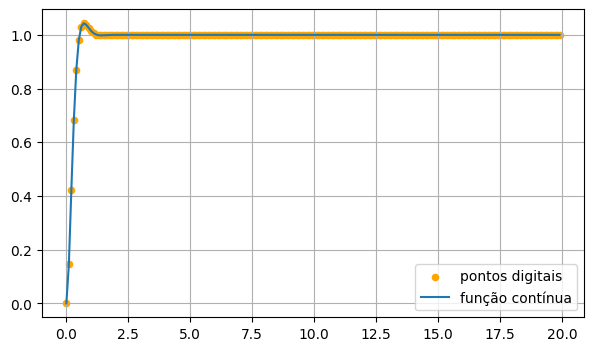

In [19]:
time    = np.arange(0, 20, dt)
digital = [0.0] + [filter.update(1) for k in range(1, len(time))]
time, continuous = ctl.step_response(C, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, digital, label='pontos digitais', color='orange', s=20)
plt.plot(time, continuous, label='função contínua')
plt.grid(), plt.legend()
plt.show()

- Comparando o filtro digital com o filtro perfeito

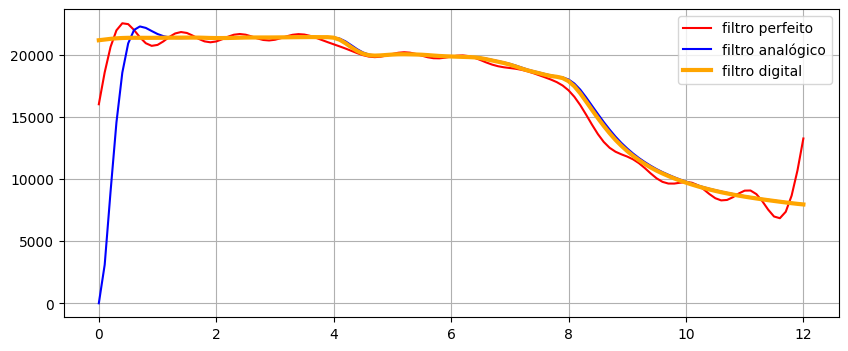

In [20]:
for i in range(1000): filter.update(df.loc[df.time < 5].analog.mean())

xTest, yTest  = df.time.values, df.analog.values
timeArray     = np.linspace(xTest[0], xTest[-1], len(xTest))
time, reponse = ctl.forced_response(C, T=timeArray, U=yTest)


plt.figure(figsize=(10, 4))
plt.plot(xData, yData, label='filtro perfeito', color='red')
plt.plot(time, reponse, label='filtro analógico', color='blue')
plt.plot(xTest, [filter.update(y) for y in yTest], label='filtro digital', color='orange', linewidth=3)
plt.legend()
plt.grid()

# COMPARAÇÃO GERAL DOS DADOS

,time,analog
0,0.0,21557
1,0.1,21527
2,0.2,21500
3,0.3,21476
4,0.4,21453


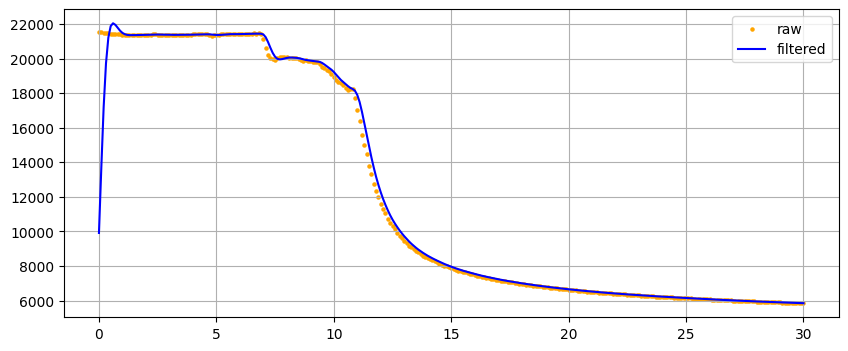

In [21]:
df = pd.read_csv(path).reset_index(drop=True)

df = normalizeTable(df, 'time', dt)
display(df.head())

plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.analog, color='orange', s=5, label='raw')
plt.plot(df.time, [filter.update(y) for y in df.analog], color='blue', label='filtered')

plt.grid()
plt.legend()